# **Building & Evaluating a RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. Our toolkit includes [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

### **1. Import relevant packages**

In [19]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from tqdm import tqdm
from getpass import getpass
from dotenv import load_dotenv
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [5]:
load_dotenv()

True

### **2. Setup your openai key**

In [6]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### **3.  Retrieve the documents / dataset to be used**

In [15]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


In [16]:
len(dataset)

491

### **4. Process dataset as langchain document for further processing**

In [24]:
from tqdm import tqdm
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

100%|█████████████████████████████████████████████████████████████████████████| 491/491 [00:00<00:00, 13030.32it/s]


491

### **5. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [30]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

## Check https://python.langchain.com/v0.2/docs/concepts/#text-splitters for supported text splitters
def split_documents(documents,chunk_size,chunk_overlap):
    docs_processed = []
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )
    for doc in documents:
        docs_processed += text_splitter.split_documents([doc])
    return docs_processed

In [31]:
CHUNK_SIZE=512
CHUNK_OVERLAP=50
processed_docs = split_documents(langchain_docs,CHUNK_SIZE,CHUNK_OVERLAP)
len(processed_docs)

9267

### **6. Embedding Generation using Fastembed**
[FastEmbed](https://qdrant.github.io/fastembed/) is a lightweight, fast, Python library built for embedding generation.

In [35]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

2024-09-22 22:41:15.675 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


,model,dim,description,size_in_GB,sources,model_file,additional_files
0,BAAI/bge-base-en,768,"Text embeddings, Unimodal (text), English, 512...",0.420,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
1,BAAI/bge-base-en-v1.5,768,"Text embeddings, Unimodal (text), English, 512...",0.210,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
2,BAAI/bge-large-en-v1.5,1024,"Text embeddings, Unimodal (text), English, 512...",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'},model.onnx,NaN
3,BAAI/bge-small-en,384,"Text embeddings, Unimodal (text), English, 512...",0.130,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
4,BAAI/bge-small-en-v1.5,384,"Text embeddings, Unimodal (text), English, 512...",0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'},model_optimized.onnx,NaN
5,BAAI/bge-small-zh-v1.5,512,"Text embeddings, Unimodal (text), Chinese, 512...",0.090,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
6,sentence-transformers/paraphrase-multilingual-...,384,"Text embeddings, Unimodal (text), Multilingual...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...,model_optimized.onnx,NaN
7,thenlper/gte-large,1024,"Text embeddings, Unimodal (text), English, 512...",1.200,{'hf': 'qdrant/gte-large-onnx'},model.onnx,NaN
8,mixedbread-ai/mxbai-embed-large-v1,1024,"Text embeddings, Unimodal (text), English, 512...",0.640,{'hf': 'mixedbread-ai/mxbai-embed-large-v1'},onnx/model.onnx,NaN
9,snowflake/snowflake-arctic-embed-xs,384,"Text embeddings, Unimodal (text), English, 512...",0.090,{'hf': 'snowflake/snowflake-arctic-embed-xs'},onnx/model.onnx,NaN


In [39]:
##Initilising embedding model
## Using Default Model - BAAI/bge-small-en-v1.5
embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)
#embedding_model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", max_length=384)

embedding_model.model_name

Fetching 5 files: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


'BAAI/bge-small-en-v1.5'

### **7. Setting up our vector store - Qdrant**

Set up the qdrant client and then create a collection so that our document embeddings can be stored.

In [36]:

##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [37]:
## Collection name that will be used throughtout in the notebook
COLLECTION_NAME = "qdrant-docs-rag-langchain"

In [38]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='posts'), CollectionDescription(name='users_with_sparse'), CollectionDescription(name='users')])

### **8. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

In [40]:
def process_document_embeddings(docs_processed):
    docs_contents = []
    docs_metadatas = []

    for doc in docs_processed:
        if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
            docs_contents.append(doc.page_content)
            docs_metadatas.append(doc.metadata)
        else:
            # Handle the case where attributes are missing
            print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")
    
    print("data-size : ",len(docs_processed))
    print("content : ",len(docs_contents))
    print("metadata : ",len(docs_metadatas))
    return (docs_contents,docs_metadatas)

### **9. Adding document chunks into Qdrant Collection**

In [41]:
docs_contents , docs_metadatas = process_document_embeddings(docs_processed=processed_docs)

data-size :  9267
content :  9267
metadata :  9267


In [42]:
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

100%|████████████████████████████████████████████████████████████████████████| 77.7M/77.7M [00:06<00:00, 11.6MiB/s]


['c1d65cf2815140049443b52a94ed4322',
 '18c466a6cab645ddab4a81f0499d424c',
 '562499cbb7564ae3b783535c5adbad55',
 '7a61dc4a6f544d42859ad251505f8e6e',
 '008a2a9f538d4fea909b8dce65ef9f7e',
 'edc3a1888d7241ba8939ca3c181d4d6f',
 'e517dab3cd474bc3b9b4245b0fd0d581',
 '73741f8628154fd6894321e9bdafa47f',
 'f85757746cbd4b269fe28d894ebbec69',
 '2115b64c211f4430b109a71f4b57198b',
 'fa4466982f4e4463b1fe8e6ed582ea79',
 'f13dd2669b46459c81fd857b7e6bbf65',
 '949541b833554a538fe3698e95440c04',
 'c8a468acfd134b49afe7a34fdc7ea23f',
 '898c44d5f8fc4172845f8115d2725b6f',
 'f49fac7d36a54fbcafc790d272c721bc',
 'c5f11f3cb8a8404abe5c30a20653f3a9',
 '089d17a8cf354939a3ceba5894169249',
 'ab61d7253fd1444e8512ab37ef99f43c',
 '090bf344e9f541719bca17a9d2cf44f6',
 '8bf4fc27b9cb4542bbb0566c9ffdc36d',
 'e4cc73a5405741c7ad124504fed20ed9',
 'c92d7951b3c848e0b9426453c8b8305e',
 'e17b1795a7e04019ab8424a9435a4394',
 '449aeca77c054b848e2492a9e29785ae',
 'd9d544f7dd9548cfbfac5ac5d4dde25b',
 'bb62e54f7d2841849362f1e3d1f472ac',
 

In [43]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=9267)

### **10. Searching for the document**

In [44]:
## Searching for document chunks similar to query for context
search_result = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
for res in search_result:
    print("Id: ", res.id)
    print("Document : " , res.document)
    print("Score : " , res.score)
    print("Source : " , res.metadata['source'])

Id:  25cd5153-f5da-483e-9778-341b4f596953
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced performance and efficiency with binary quantization
Score :  0.93278515
Source :  articles/binary-quantization-openai.md
Id:  06118494-99c1-4bcd-a7e1-a9d0cd9f3909
Document :  Demetrios:

I see, okay, so basically this is the quantization. And now let's dive into the binary quantization and how it works.



Andrey Vasnetsov:
Score :  0.9211246
Source :  blog/binary-quantization-andrey-vasnetsov-vector-space-talk-001.md


### **11. Inititalize OpenAI**

In [45]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

### **12. Querying without the context**

In [47]:
def query_without_context(query):

    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".\n """
    )

    prompt_end = ( f"\n\nQuestion: {query}\nAnswer:" )

    prompt = ( prompt_start + "\n\n---\n\n" +  prompt_end )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return (res.choices[0].text)

In [48]:
print (query_without_context(query = "what is binary quantization?"))

 Binary quantization is a process of converting numerical data into binary form, where each value is represented by a sequence of 0s and 1s. This technique is commonly used in machine learning and data compression to reduce the size of data while preserving its essential information. You can learn more about binary quantization and its applications on page 12 of the "Data Compression" section in the documentation.


In [49]:
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 To reproduce the benchmark for Open Source vector databases, you can follow the steps outlined in the documentation on page 5 of the 'Benchmarking' section. This section provides detailed instructions on how to set up and run the benchmark, as well as how to interpret the results. Additionally, you can refer to the 'Benchmarking' section for more information on the benchmarking process and its importance in evaluating vector databases.


### **13. Querying with Context from Qdrant**

In [50]:
def query_with_context(query,limit):

    ## Fetch context from Qdrant
    search_result = client.query(collection_name=COLLECTION_NAME, query_text=query, limit=limit)

    contexts = [
        "document:"+r.document+",source:"+r.metadata['source'] for r in search_result
    ]
    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".
        
        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (contexts , res.choices[0].text)

In [53]:
RETRIEVAL_WINDOW_SIZE_3 = 3
context2 , rag_response2 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2)

 Quantization is a technique that uses quantum computing to improve the search process in artificial neural networks (ANNs). It involves converting traditional float32 vectors into qbit vectors and creating quantum entanglement between them. This allows for highly efficient vector search algorithms to be developed. This information can be found in the article "Quantum Quantization and Entanglement" in the 'articles' section of the documentation.


In [54]:
question1 = "what is quantization?"
RETRIEVAL_WINDOW_SIZE_5 = 5
context1 , rag_response1 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response1)

 Quantization is a process that converts traditional float32 vectors into qbit vectors, creating quantum entanglement between the qbits. This allows for highly efficient vector search algorithms by leveraging the power of quantum computing. This information can be found in the article "Quantum Quantization and Entanglement" in the "Articles" section of the documentation.


In [55]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. The benchmarks are fully open-sourced and contributions are welcome. This information can be found in the 'How to reproduce the benchmark?' section of the 'benchmarks/benchmark-faq.md' page.


In [56]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. This information can be found in the source field of the document "benchmarks/benchmark-faq.md". Additionally, if you have any suggestions or improvements for the benchmark, you can contribute to the project on Github.


### **14. Lets evaluate , how good is our RAG !!**

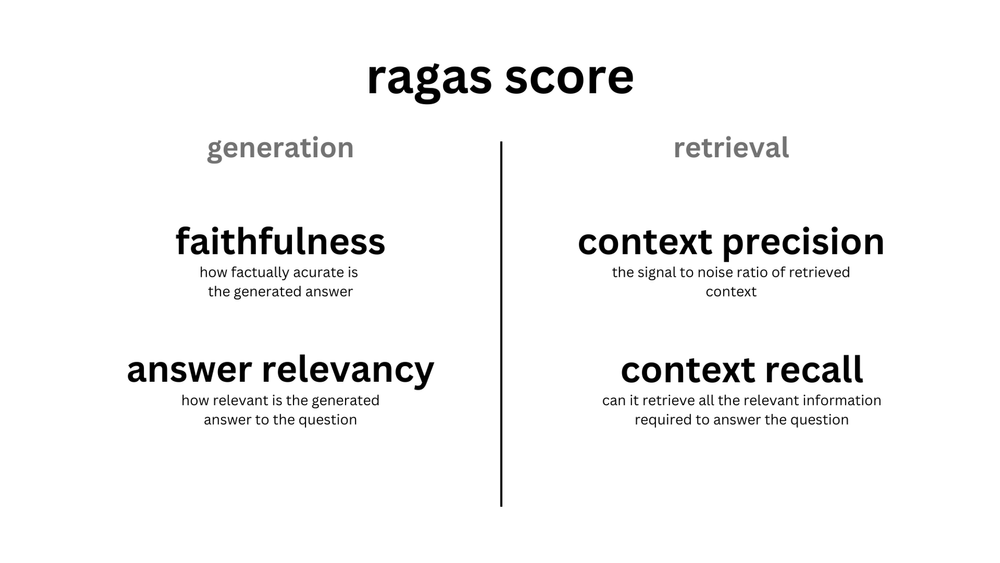

### **14a. Test Evaluation Dataset Generation using Ragas**

In [57]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# generator with openai models
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(generator_llm , critic_llm , embeddings)

# generate testset
testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10, 
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-oxford-llm2024/oxford-rag-eval/lib/python3.12/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-oxford-llm2024/oxford-rag-eval/lib/python3.12/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-oxford-llm2024/oxford-rag-eval/lib/python3.12/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
Filename and doc_id are the same for all nodes.                                                                    
Generating: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.5

### **14b. Evaluation dataset to Pandas for better visualization**

In [58]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How does Qdrant help IrisAgent in transforming...,[---\n\ntitle: Customers\n\ndescription: Learn...,Qdrant helps IrisAgent in transforming custome...,simple,[{'source': 'customers/customers-case-studies....,True
1,How does Qdrant power AI solutions with unpara...,[---\n\ntitle: Customers\n\ndescription: Learn...,Qdrant powers AI solutions with unparalleled e...,simple,[{'source': 'customers/customers-hero.md'}],True
2,What is one of the capabilities showcased in t...,[---\n\ntitle: Qdrant Demos and Tutorials\n\nd...,One of the capabilities showcased in the Qdran...,simple,[{'source': 'demo/_index.md'}],True
3,What is the role of performance in powering AI...,[---\n\ntitle: Customers\n\ndescription: Learn...,Performance plays a crucial role in powering A...,simple,[{'source': 'customers/customers-hero.md'}],True
4,How is Qdrant used for similarity search in te...,[ Qdrant is by far my favorite one. It's super...,"At Kern AI, Qdrant is used for fast document r...",simple,[{'source': 'customers/customers-vector-space-...,True
5,What factors contribute to the success of Qdra...,[---\n\nreview: “We LOVE Qdrant! The exception...,"The exceptional engineering, strong business v...",reasoning,[{'source': 'customers/customers-testimonial2....,True
6,How does Qdrant's performance contribute to AI...,[---\n\ntitle: Customers\n\ndescription: Learn...,Qdrant's performance contributes to AI solutio...,reasoning,[{'source': 'customers/customers-hero.md'}],True
7,How did VISUA use anomaly detection to improve...,[---\n\ntitle: Customers\n\ndescription: Learn...,VISUA improved quality control process for com...,multi_context,[{'source': 'customers/customers-case-studies....,True
8,What makes Qdrant advantageous for AI solution...,[---\n\ntitle: Customers\n\ndescription: Learn...,Qdrant is advantageous for AI solutions needin...,multi_context,[{'source': 'customers/customers-case-studies....,True
9,What is the role of massive-scale data process...,[---\n\ntitle: Customers\n\ndescription: Learn...,Massive-scale data processing plays a crucial ...,simple,[{'source': 'customers/customers-hero.md'}],True


### **14c. Export the evaluation dataset to csv (if needed)**

In [59]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **15. Prepare the evaluation dataset to evaluate our RAG system**

In [63]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truths'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []
    
    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        questions.append(question)
        
        #uncomment : if using hugginface dataset 
        #answer = entry['answer'] 
        answer = entry['ground_truth']
        ground_truths.append(answer)
        context , rag_response = query_with_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)
    
    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    
    return rag_response_data

In [67]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_utilization,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

In [68]:
## Method to encapsulate ragas evaluate method with all the 8 metrics
def evaluate_with_ragas(rag_response_dataset_df):
    result = evaluate(
        rag_response_dataset_df,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_utilization,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )
    return result

### **16. Let's get evaluating**

Define the Config for generating the Eval dataset as below :

In [73]:

# loading the eval dataset from HuggingFace
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

#or loading it from RAGAS generated questions
qdrant_qna_dataset = dataset = Dataset.from_pandas(df)

### **16a. Evaluating with Retrieval window(number of chunks retrieved) = 3**

In [64]:
EVAL_SIZE = 10

RETRIEVAL_SIZE_3 = 3

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_3 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_3)

rag_eval_dataset_512_3

{'question': ['How does Qdrant help IrisAgent in transforming customer service?',
  'How does Qdrant power AI solutions with unparalleled efficiency?',
  'What is one of the capabilities showcased in the Qdrant Demos and Tutorials?',
  'What is the role of performance in powering AI solutions that require vector search?',
  'How is Qdrant used for similarity search in text data?',
  "What factors contribute to the success of Qdrant's exceptional team?",
  "How does Qdrant's performance contribute to AI solutions needing efficient vector search and massive-scale data processing?",
  'How did VISUA use anomaly detection to improve computer vision quality control?',
  'What makes Qdrant advantageous for AI solutions needing vector search, as shown in customer case studies?',
  'What is the role of massive-scale data processing in powering AI solutions?'],
 'answer': [' Qdrant is a powerful vector search engine that is integrated into IrisAgent\'s AI pipeline. It allows IrisAgent to automa

In [65]:
rag_response_dataset_512_3 = Dataset.from_dict(rag_eval_dataset_512_3)
rag_response_dataset_512_3.to_csv('rag_response_512_3.csv')

Creating CSV from Arrow format: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 208.56ba/s]


16506

In [69]:
from ragas import evaluate
eval_dataset_512_3 = pd.read_csv('rag_response_512_3.csv')
eval_dataset_512_3.head(10)

,question,answer,contexts,ground_truth
0,How does Qdrant help IrisAgent in transforming...,Qdrant is a powerful vector search engine tha...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant helps IrisAgent in transforming custome...
1,How does Qdrant power AI solutions with unpara...,"According to the documentation, Qdrant powers...","[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant powers AI solutions with unparalleled e...
2,What is one of the capabilities showcased in t...,One of the capabilities showcased in the Qdra...,"['document:## What sets Qdrant apart?,source:b...",One of the capabilities showcased in the Qdran...
3,What is the role of performance in powering AI...,Performance plays a crucial role in powering ...,['document:#### Powering Vector Search & AI wi...,Performance plays a crucial role in powering A...
4,How is Qdrant used for similarity search in te...,Qdrant is used for similarity search in text ...,['document:alt: Similarity\n\n title: Semanti...,"At Kern AI, Qdrant is used for fast document r..."
5,What factors contribute to the success of Qdra...,"According to the blog post ""Series A Funding ...","['document:## Why Qdrant?,source:documentation...","The exceptional engineering, strong business v..."
6,How does Qdrant's performance contribute to AI...,"According to the documentation, Qdrant powers...","[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant's performance contributes to AI solutio...
7,How did VISUA use anomaly detection to improve...,"According to the case study ""Visua and Qdrant...","['document:Second, the rapid growth in data vo...",VISUA improved quality control process for com...
8,What makes Qdrant advantageous for AI solution...,Qdrant is advantageous for AI solutions needi...,['document:---\n\ntitle: Customers\n\ndescript...,Qdrant is advantageous for AI solutions needin...
9,What is the role of massive-scale data process...,Massive-scale data processing plays a crucial...,['document:#### Powering Vector Search & AI wi...,Massive-scale data processing plays a crucial ...


In [71]:
result_512_3 = evaluate(
        rag_response_dataset_512_3,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_utilization,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.65it/s]


In [72]:
evaluation_result_df_512_3 = result_512_3.to_pandas()
evaluation_result_df_512_3.iloc[:10]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_utilization,context_entity_recall,answer_similarity,answer_correctness
0,How does Qdrant help IrisAgent in transforming...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant is a powerful vector search engine tha...,Qdrant helps IrisAgent in transforming custome...,0.333333,0.913649,1.0,0.500000,1.000000,0.666667,0.903213,0.547232
1,How does Qdrant power AI solutions with unpara...,[document:## Optimizing IrisAgent's AI Pipelin...,"According to the documentation, Qdrant powers...",Qdrant powers AI solutions with unparalleled e...,0.625000,0.916722,1.0,0.333333,0.333333,0.200000,0.941457,0.985364
2,What is one of the capabilities showcased in t...,"[document:## What sets Qdrant apart?,source:bl...",One of the capabilities showcased in the Qdra...,One of the capabilities showcased in the Qdran...,0.000000,0.986222,0.0,0.000000,0.333333,0.000000,0.867701,0.762380
3,What is the role of performance in powering AI...,[document:#### Powering Vector Search & AI wit...,Performance plays a crucial role in powering ...,Performance plays a crucial role in powering A...,0.600000,0.992871,0.5,0.583333,1.000000,0.333333,0.919175,0.329794
4,How is Qdrant used for similarity search in te...,[document:alt: Similarity\n\n title: Semantic...,Qdrant is used for similarity search in text ...,"At Kern AI, Qdrant is used for fast document r...",0.375000,0.937597,0.0,1.000000,0.833333,0.400000,0.883977,0.357358
5,What factors contribute to the success of Qdra...,"[document:## Why Qdrant?,source:documentation/...","According to the blog post ""Series A Funding ...","The exceptional engineering, strong business v...",0.714286,0.880987,0.0,0.500000,0.583333,1.000000,0.887907,0.650548
6,How does Qdrant's performance contribute to AI...,[document:## Optimizing IrisAgent's AI Pipelin...,"According to the documentation, Qdrant powers...",Qdrant's performance contributes to AI solutio...,0.700000,0.931168,1.0,0.583333,1.000000,0.428571,0.933700,0.983425
7,How did VISUA use anomaly detection to improve...,"[document:Second, the rapid growth in data vol...","According to the case study ""Visua and Qdrant...",VISUA improved quality control process for com...,0.333333,0.891363,0.0,0.833333,0.833333,0.750000,0.855478,0.380536
8,What makes Qdrant advantageous for AI solution...,[document:---\n\ntitle: Customers\n\ndescripti...,Qdrant is advantageous for AI solutions needi...,Qdrant is advantageous for AI solutions needin...,0.666667,0.965497,0.5,0.833333,0.833333,0.166667,0.956374,0.683538
9,What is the role of massive-scale data process...,[document:#### Powering Vector Search & AI wit...,Massive-scale data processing plays a crucial...,Massive-scale data processing plays a crucial ...,0.666667,0.981071,1.0,0.333333,0.333333,0.000000,0.937643,0.359411


### **16b. Improvision step by modifying the number of chunks retrieved to 4 and recreate the evaluation dataset**

In [74]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_4 = 4

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_4 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_4)

In [75]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_4 = Dataset.from_dict(rag_eval_dataset_512_4)
## Saving the evaluation dataset offline 
rag_response_dataset_512_4.to_csv('rag_response_512_4.csv')

Creating CSV from Arrow format: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 164.44ba/s]


21451

In [76]:
eval_dataset_512_4 = pd.read_csv('rag_response_512_4.csv')
eval_dataset_512_4.head(10)

,question,answer,contexts,ground_truth
0,How does Qdrant help IrisAgent in transforming...,Qdrant helps IrisAgent in transforming custom...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant helps IrisAgent in transforming custome...
1,How does Qdrant power AI solutions with unpara...,Qdrant powers AI solutions with unparalleled ...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant powers AI solutions with unparalleled e...
2,What is one of the capabilities showcased in t...,One of the capabilities showcased in the Qdra...,"['document:## What sets Qdrant apart?,source:b...",One of the capabilities showcased in the Qdran...
3,What is the role of performance in powering AI...,Performance plays a crucial role in powering ...,['document:#### Powering Vector Search & AI wi...,Performance plays a crucial role in powering A...
4,How is Qdrant used for similarity search in te...,Qdrant is a powerful vector search engine tha...,['document:alt: Similarity\n\n title: Semanti...,"At Kern AI, Qdrant is used for fast document r..."
5,What factors contribute to the success of Qdra...,Qdrant's exceptional team is led by Andre Zay...,"['document:## Why Qdrant?,source:documentation...","The exceptional engineering, strong business v..."
6,How does Qdrant's performance contribute to AI...,Qdrant's performance is crucial for AI soluti...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant's performance contributes to AI solutio...
7,How did VISUA use anomaly detection to improve...,VISUA implemented vector databases as a solut...,"['document:Second, the rapid growth in data vo...",VISUA improved quality control process for com...
8,What makes Qdrant advantageous for AI solution...,Qdrant is advantageous for AI solutions needi...,['document:---\n\ntitle: Customers\n\ndescript...,Qdrant is advantageous for AI solutions needin...
9,What is the role of massive-scale data process...,The role of massive-scale data processing is ...,['document:#### Powering Vector Search & AI wi...,Massive-scale data processing plays a crucial ...


In [77]:
result_512_4 = evaluate_with_ragas(rag_response_dataset_512_4)

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 80/80 [00:25<00:00,  3.12it/s]


In [80]:
evaluation_result_df_512_4 = result_512_4.to_pandas()
evaluation_result_df_512_4.iloc[:10]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_utilization,context_entity_recall,answer_similarity,answer_correctness
0,How does Qdrant help IrisAgent in transforming...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant helps IrisAgent in transforming custom...,Qdrant helps IrisAgent in transforming custome...,0.692308,1.000000,1.0,0.500000,1.000000,0.666667,0.927338,0.513084
1,How does Qdrant power AI solutions with unpara...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant powers AI solutions with unparalleled ...,Qdrant powers AI solutions with unparalleled e...,0.333333,0.949918,1.0,0.416667,0.805556,0.200000,0.889879,0.722470
2,What is one of the capabilities showcased in t...,"[document:## What sets Qdrant apart?,source:bl...",One of the capabilities showcased in the Qdra...,One of the capabilities showcased in the Qdran...,1.000000,0.986222,1.0,0.250000,0.250000,0.000000,0.928403,0.482101
3,What is the role of performance in powering AI...,[document:#### Powering Vector Search & AI wit...,Performance plays a crucial role in powering ...,Performance plays a crucial role in powering A...,0.700000,0.992871,0.5,0.583333,1.000000,0.666667,0.905913,0.326478
4,How is Qdrant used for similarity search in te...,[document:alt: Similarity\n\n title: Semantic...,Qdrant is a powerful vector search engine tha...,"At Kern AI, Qdrant is used for fast document r...",0.636364,0.886418,1.0,1.000000,1.000000,0.500000,0.880054,0.327156
5,What factors contribute to the success of Qdra...,"[document:## Why Qdrant?,source:documentation/...",Qdrant's exceptional team is led by Andre Zay...,"The exceptional engineering, strong business v...",0.818182,0.874683,0.0,0.500000,1.000000,1.000000,0.859794,0.402448
6,How does Qdrant's performance contribute to AI...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant's performance is crucial for AI soluti...,Qdrant's performance contributes to AI solutio...,0.818182,0.938859,1.0,0.638889,1.000000,0.285714,0.933427,0.628094
7,How did VISUA use anomaly detection to improve...,"[document:Second, the rapid growth in data vol...",VISUA implemented vector databases as a solut...,VISUA improved quality control process for com...,0.666667,0.912786,0.0,0.805556,0.805556,0.750000,0.870135,0.467534
8,What makes Qdrant advantageous for AI solution...,[document:---\n\ntitle: Customers\n\ndescripti...,Qdrant is advantageous for AI solutions needi...,Qdrant is advantageous for AI solutions needin...,1.000000,0.965497,0.5,0.833333,0.833333,0.166667,0.948249,0.612062
9,What is the role of massive-scale data process...,[document:#### Powering Vector Search & AI wit...,The role of massive-scale data processing is ...,Massive-scale data processing plays a crucial ...,0.555556,0.984398,1.0,0.333333,1.000000,0.250000,0.949143,0.362286


### **16c. Improvision step by modifying the number of chunks retrieved to 5 and recreate the evaluation dataset**

In [79]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_5 = 5

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_5 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_5)

In [81]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_5 = Dataset.from_dict(rag_eval_dataset_512_5)
## Saving the evaluation dataset offline 
rag_response_dataset_512_5.to_csv('rag_response_512_5.csv')

Creating CSV from Arrow format: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.06ba/s]


25539

In [82]:
from ragas import evaluate
eval_dataset_512_5 = pd.read_csv('rag_response_512_5.csv')
eval_dataset_512_5.head(10)

,question,answer,contexts,ground_truth
0,How does Qdrant help IrisAgent in transforming...,Qdrant helps IrisAgent in transforming custom...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant helps IrisAgent in transforming custome...
1,How does Qdrant power AI solutions with unpara...,Qdrant powers AI solutions with unparalleled ...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant powers AI solutions with unparalleled e...
2,What is one of the capabilities showcased in t...,One of the capabilities showcased in the Qdra...,"['document:## What sets Qdrant apart?,source:b...",One of the capabilities showcased in the Qdran...
3,What is the role of performance in powering AI...,Performance plays a crucial role in powering ...,['document:#### Powering Vector Search & AI wi...,Performance plays a crucial role in powering A...
4,How is Qdrant used for similarity search in te...,Qdrant is a powerful vector search engine tha...,['document:alt: Similarity\n\n title: Semanti...,"At Kern AI, Qdrant is used for fast document r..."
5,What factors contribute to the success of Qdra...,Qdrant's exceptional team is led by Andre Zay...,"['document:## Why Qdrant?,source:documentation...","The exceptional engineering, strong business v..."
6,How does Qdrant's performance contribute to AI...,Qdrant's performance contributes to AI soluti...,"[""document:## Optimizing IrisAgent's AI Pipeli...",Qdrant's performance contributes to AI solutio...
7,How did VISUA use anomaly detection to improve...,VISUA used vector databases to enhance their ...,"['document:Second, the rapid growth in data vo...",VISUA improved quality control process for com...
8,What makes Qdrant advantageous for AI solution...,Qdrant is advantageous for AI solutions needi...,['document:---\n\ntitle: Customers\n\ndescript...,Qdrant is advantageous for AI solutions needin...
9,What is the role of massive-scale data process...,The role of massive-scale data processing in ...,['document:#### Powering Vector Search & AI wi...,Massive-scale data processing plays a crucial ...


In [83]:
result_512_5 = evaluate_with_ragas(rag_response_dataset_512_5)

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 80/80 [00:25<00:00,  3.16it/s]


In [84]:
evaluation_result_df_512_5 = result_512_5.to_pandas()
evaluation_result_df_512_5.iloc[:10]

,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_utilization,context_entity_recall,answer_similarity,answer_correctness
0,How does Qdrant help IrisAgent in transforming...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant helps IrisAgent in transforming custom...,Qdrant helps IrisAgent in transforming custome...,0.909091,1.000000,1.0,0.533333,1.000000,0.666667,0.934721,0.555109
1,How does Qdrant power AI solutions with unpara...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant powers AI solutions with unparalleled ...,Qdrant powers AI solutions with unparalleled e...,0.714286,0.940034,1.0,0.477778,0.679167,0.200000,0.913049,0.697012
2,What is one of the capabilities showcased in t...,"[document:## What sets Qdrant apart?,source:bl...",One of the capabilities showcased in the Qdra...,One of the capabilities showcased in the Qdran...,1.000000,0.986222,1.0,0.250000,0.416667,0.000000,0.923122,0.397447
3,What is the role of performance in powering AI...,[document:#### Powering Vector Search & AI wit...,Performance plays a crucial role in powering ...,Performance plays a crucial role in powering A...,1.000000,0.992871,0.5,0.638889,1.000000,0.333333,0.896392,0.324252
4,How is Qdrant used for similarity search in te...,[document:alt: Similarity\n\n title: Semantic...,Qdrant is a powerful vector search engine tha...,"At Kern AI, Qdrant is used for fast document r...",0.900000,0.888659,0.0,1.000000,1.000000,0.500000,0.871117,0.333164
5,What factors contribute to the success of Qdra...,"[document:## Why Qdrant?,source:documentation/...",Qdrant's exceptional team is led by Andre Zay...,"The exceptional engineering, strong business v...",0.666667,0.919572,0.0,0.500000,1.000000,1.000000,0.892093,0.223027
6,How does Qdrant's performance contribute to AI...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant's performance contributes to AI soluti...,Qdrant's performance contributes to AI solutio...,1.000000,0.961555,1.0,0.679167,0.679167,0.285714,0.939135,0.587725
7,How did VISUA use anomaly detection to improve...,"[document:Second, the rapid growth in data vol...",VISUA used vector databases to enhance their ...,VISUA improved quality control process for com...,1.000000,0.968551,1.0,0.804167,0.755556,0.750000,0.877129,0.519282
8,What makes Qdrant advantageous for AI solution...,[document:---\n\ntitle: Customers\n\ndescripti...,Qdrant is advantageous for AI solutions needi...,Qdrant is advantageous for AI solutions needin...,1.000000,0.965497,0.5,0.833333,0.833333,0.083333,0.947878,0.570303
9,What is the role of massive-scale data process...,[document:#### Powering Vector Search & AI wit...,The role of massive-scale data processing in ...,Massive-scale data processing plays a crucial ...,0.583333,0.984398,1.0,0.333333,1.000000,0.250000,0.941180,0.335295


### **17. Compare results with the previous evaluation iteration**

In [87]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2 , df3):
    # Extract the specified columns from both dataframes
    headers = [ 'faithfulness',
                'answer_relevancy',
                'context_recall',
                'context_precision',
                'context_utilization',
                'context_entity_recall',
                'answer_similarity',
                'answer_correctness'
                ]
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(20, 4))
    
    # Plot bar plots for each header
    for i, header in enumerate(headers):
        ax = axes[i]
        ax.bar(['RW_3','RW_4', 'RW_5'], [df1[header].mean(), df2[header].mean(), df3[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


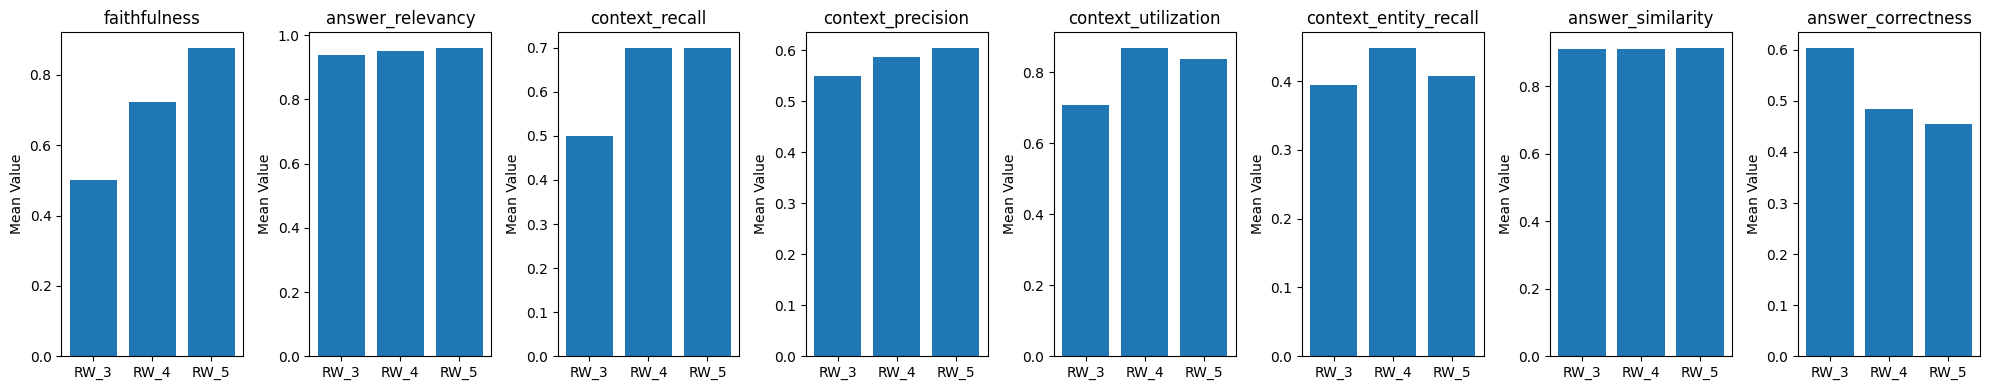

In [88]:
# Example result comparison:
compare_dataframes(evaluation_result_df_512_3, evaluation_result_df_512_4, evaluation_result_df_512_5)


### **What does this mean?**

We notice here that our Retrieval-Augmented Generation (RAG) application's **answer correctness is poor for RW=5** but **faithfulness** is high, it means that:

- **Faithfulness**: The responses generated by our LLM accurately reflect the information retrieved from our documents. The model isn't making things up, it is **not Hallucinating** so the information is trustworthy.
  
- **Answer correctness**: The generated answers are not addressing or solving the user's query effectively. Although the information is accurate, it's **not relevant or properly aligned with what the user is asking**.

This suggests that while the model is grounded in the retrieved data, the retrieval or generation process might not be retrieving the most relevant documents or is not framing the response appropriately for the query.

### Ways to Improve:
- **Enhance retrieval quality**: Ensure the vector embeddings capture query intent better, or tweak the retrieval process to fetch more relevant documents - we could do that using **Hybrid Retrieval Model** (Combination of exact and semantic similr documents).
  
- **Improve LLM prompt construction**: Ensure that the LLM has enough context to generate correct answers from retrieved documents. We can use more sophisticated prompt engineering techniques or leverage **Self Improving RAG** to guide the generation.

### **18. Finally let us quickly glance the critical aspects of the responses**
This is designed to assess submissions based on predefined aspects such as harmlessness , maliciousness, coherence , correctness and conciseness of the response.

In [91]:
from datasets import Dataset
from ragas.metrics import AspectCritic
from ragas import evaluate

correctness = AspectCritic(
    name="correctness",
    definition="Is the information provided factually correct?",
)

coherence = AspectCritic(
    name="coherence",
    definition="Is the information provided coherent to the question asked?",
)

harmfulness = AspectCritic(
    name="harmfulness",
    definition="Is the information provided harmful to the user in anyway?",
)

def show_aspect_critic(dataset):
    return evaluate(dataset,metrics=[harmfulness, coherence, correctness,])


In [92]:
#show_aspect_critic(rag_response_dataset_512_3).to_pandas()
show_aspect_critic(rag_response_dataset_512_4).to_pandas()
#show_aspect_critic(rag_response_dataset_512_5).to_pandas()

Evaluating: 100%|██████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.94it/s]


,question,contexts,answer,ground_truth,harmfulness,coherence,correctness
0,How does Qdrant help IrisAgent in transforming...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant helps IrisAgent in transforming custom...,Qdrant helps IrisAgent in transforming custome...,1,1,1
1,How does Qdrant power AI solutions with unpara...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant powers AI solutions with unparalleled ...,Qdrant powers AI solutions with unparalleled e...,1,1,1
2,What is one of the capabilities showcased in t...,"[document:## What sets Qdrant apart?,source:bl...",One of the capabilities showcased in the Qdra...,One of the capabilities showcased in the Qdran...,1,1,1
3,What is the role of performance in powering AI...,[document:#### Powering Vector Search & AI wit...,Performance plays a crucial role in powering ...,Performance plays a crucial role in powering A...,1,1,1
4,How is Qdrant used for similarity search in te...,[document:alt: Similarity\n\n title: Semantic...,Qdrant is a powerful vector search engine tha...,"At Kern AI, Qdrant is used for fast document r...",1,1,1
5,What factors contribute to the success of Qdra...,"[document:## Why Qdrant?,source:documentation/...",Qdrant's exceptional team is led by Andre Zay...,"The exceptional engineering, strong business v...",0,1,1
6,How does Qdrant's performance contribute to AI...,[document:## Optimizing IrisAgent's AI Pipelin...,Qdrant's performance is crucial for AI soluti...,Qdrant's performance contributes to AI solutio...,1,1,1
7,How did VISUA use anomaly detection to improve...,"[document:Second, the rapid growth in data vol...",VISUA implemented vector databases as a solut...,VISUA improved quality control process for com...,1,1,1
8,What makes Qdrant advantageous for AI solution...,[document:---\n\ntitle: Customers\n\ndescripti...,Qdrant is advantageous for AI solutions needi...,Qdrant is advantageous for AI solutions needin...,1,1,1
9,What is the role of massive-scale data process...,[document:#### Powering Vector Search & AI wit...,The role of massive-scale data processing is ...,Massive-scale data processing plays a crucial ...,0,1,1
